# Deep Neural Network with Optimizers
In this notebook, I will implement several deep learning models. My focus will be on tuning initialization methods and optimization algorithms to study their impact on model accuracy.

## Initilization methods
I decided to implement three different initialization techniques:
- **Zero initialization**: initializes every parameters with a null value. It is not recommendend.
- **Random initialization**: gives random values to weights, keeping biases at zero.
- **He initialization**: we will define weights based on the following expression:
  $$w^{[l]} = np.random.randn(shape)\star np.sqrt\bigg(\frac{1}{n^{[l-1]}}\bigg)$$

<br><br>

## Optimization algorithms
I will compare the performance of four different algorithms:
- Gradient Descent
- Gradient Descent with Momentum
- RMSprop
- Adam

<br>

#### Gradient Descent
It is the standard algorithm I have been using so far.
  $$w^{[1]} := w^{[1]} - \alpha \cdot dw^{[1]} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: b^{[1]} := b^{[1]} - \alpha \cdot db^{[1]}$$
  $$w^{[2]} := w^{[2]} - \alpha \cdot dw^{[2]} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: b^{[2]} := b^{[2]} - \alpha \cdot db^{[2]}$$
  where $α$ represents the learning rate.

<br>

#### Gradient Descent with Momentum
It almost always work faster than the standard momentum.
With momentum on each iteration we:
 - Compute $dw$, $db$ on current mini-batch:
  $$V_{dw} = \beta V_{dw} + (1 - \beta) \cdot dw$$
  $$V_{db} = \beta V_{db} + (1 - \beta) \cdot db$$
 - Update parameters:
  $$w := w - \alpha \cdot V_{dw}$$
  $$b := b - \alpha \cdot V_{db}$$
Where the most common value for $\beta$ is $0.9$.

<br>

#### RMSprop (Root Mean Squared Propagation)
On each iteration $t$:
- Compute $dw$, $db$ on current mini-batch
- $S_{dw} = \beta \cdot S_{dw} + (1-\beta) \cdot dw^2$
- $S_{db} = \beta \cdot S_{db} + (1-\beta) \cdot db^2$
- $w := w - \alpha \cdot \frac{dw}{\sqrt{S_{dw}}}$
- $b := b - \alpha \cdot \frac{db}{\sqrt{S_{db}}}$

To ensure we do not divide by zero, we can add $\epsilon$ to the denominator.

<br>

#### Adam
It takes momentum and RMSprop and use them together.
We need to initialize these values: $V_{dw} = 0$, $S_{dw} = 0$, $V_{db} = 0$, $S_{db} = 0$.

On each iteration $t$:
- Compute $dw$, $db$ using current mini-batch
- Momentum:
$$v_{dw} = \beta_1 \cdot v_{dw} + (1-\beta) \cdot dw \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: v_{db} = \beta_1 \cdot v_{db} + (1-\beta) \cdot db$$
- RMSprop:
$$S_{dw} = \beta_2 \cdot S_{dw} + (1-\beta) \cdot dw^2 \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: S_{db} = \beta_2 \cdot S_{db} + (1-\beta) \cdot db^2$$
- Bias correction:
$$V_{dw}^{corrected} = \frac{V_{dw}}{(1-\beta_1^t)} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: V_{db}^{corrected} = \frac{V_{db}}{(1-\beta_1^t)}$$
$$S_{dw}^{corrected} = \frac{S_{dw}}{(1-\beta_2^t)} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: S_{db}^{corrected} = \frac{S_{db}}{(1-\beta_2^t)}$$
- Update parameters:
$$w := w - \alpha \cdot \frac{V_{dw}^{corrected}}{\sqrt{S_{dw}^{corrected} + \epsilon}} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: b := b - \alpha \cdot \frac{V_{db}^{corrected}}{\sqrt{S_{db}^{corrected} + \epsilon}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import math
from PIL import Image
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random

In [2]:
# Function to display images in a pixellated form
def display_pixellated_images(images, labels, rows=2, cols=5, title='Digits Dataset'):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray', interpolation='nearest')
        ax.set_title(f'Digit: {labels[i]}')
        ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def show_digit(image, label=False):
    plt.imshow(image, cmap='gray')
    if not label:
        plt.axis('off')
    else:
      plt.title(f'Digit: {label}')
      plt.axis('off')
    plt.show()

## Dataset
I will be using the **MNIST Digits dataset**, a collection of hand-written digits.

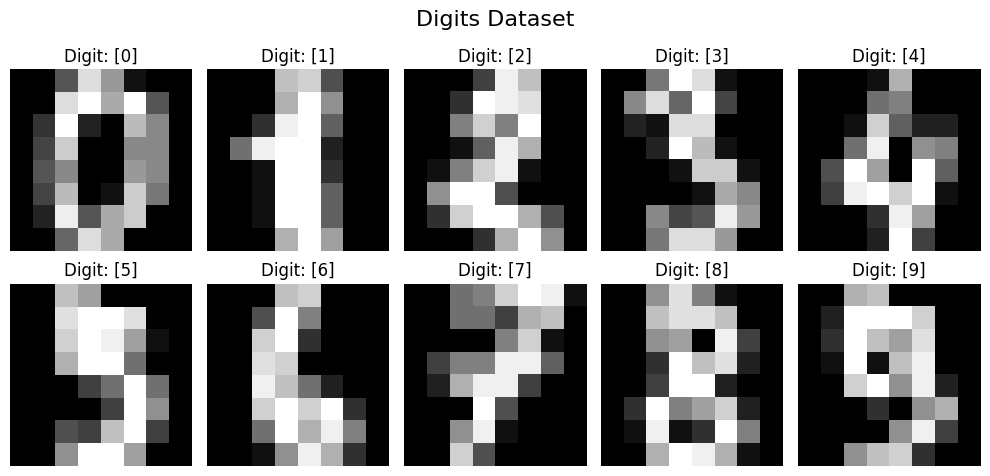

In [3]:
digits = sklearn.datasets.load_digits()
images = digits.images
labels = digits.target.reshape(-1, 1)
display_pixellated_images(images, labels)

In [4]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = encoder.fit_transform(labels)
images_flat = images.reshape(images.shape[0], -1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images_flat, one_hot_labels, test_size=0.2, random_state=42)

In [6]:
class DeepNeuralNetwork():

  def __init__(self,
               layers_dims,
               init_type='random', mini_batch_size=64,
               beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8,
               print_cost=True):

    np.random.seed(3)

    self.parameters = {}
    self.grads = {}
    self.beta = beta
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.mini_batch_size = mini_batch_size
    self.print_cost = print_cost

    L = len(layers_dims)

    if init_type == 'zero':
      for l in range(1, L):
        self.parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
        self.parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

    elif init_type == 'random':
      for l in range(1, L):
        self.parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
        self.parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

    elif init_type == 'he':
      for l in range(1, L):
        self.parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
        self.parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))


  def random_mini_batches(self, X, Y, seed=0):
    np.random.seed(seed)
    m = X.shape[1]  # number of training examples
    mini_batches = []

    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Partition (shuffled_X, shuffled_Y)
    num_complete_minibatches = m // self.mini_batch_size

    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*self.mini_batch_size : (k+1)*self.mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*self.mini_batch_size : (k+1)*self.mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handle the end case (last mini-batch < mini_batch_size)
    if m % self.mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*self.mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*self.mini_batch_size :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


  def initialize_velocity(self):
    L = len(self.parameters) // 2
    v = {}

    for l in range(1, L+1):
      v['dW' + str(l)] = np.zeros(self.parameters['W' + str(l)].shape)
      v['db' + str(l)] = np.zeros(self.parameters['b' + str(l)].shape)

    return v

  def initialize_rms(self):
    L = len(self.parameters) // 2
    s = {}

    for l in range(1, L+1):
      s['dW' + str(l)] = np.zeros(self.parameters['W' + str(l)].shape)
      s['db' + str(l)] = np.zeros(self.parameters['b' + str(l)].shape)

    return s


  def initialize_adam(self):

    L = len(self.parameters) // 2
    v = {}
    s = {}

    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(self.parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(self.parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(self.parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(self.parameters["b" + str(l)].shape)

    return v, s


  def update_parameters_gd(self):

    L = len(self.parameters) // 2

    for l in range(1, L):
      self.parameters['W' + str(l)] -= self.learning_rate * self.grads['dW' + str(l)]
      self.parameters['b' + str(l)] -= self.learning_rate * self.grads['db' + str(l)]


  def update_parameters_momentum(self):
      L = len(self.parameters) // 2

      for l in range(1, L + 1):
          self.v["dW" + str(l)] = self.beta * self.v["dW" + str(l)] + (1 - self.beta) * self.grads["dW" + str(l)]
          self.v["db" + str(l)] = self.beta * self.v["db" + str(l)] + (1 - self.beta) * self.grads["db" + str(l)]
          self.parameters["W" + str(l)] -= self.learning_rate * self.v["dW" + str(l)]
          self.parameters["b" + str(l)] -= self.learning_rate * self.v["db" + str(l)]


  def update_parameters_rms(self):
    L = len(self.parameters) // 2

    for l in range(1, L + 1):
      self.s['dW' + str(l)] = self.beta * self.s['dW' + str(l)] + (1 - self.beta) * self.grads['dW' + str(l)]**2
      self.s['db' + str(l)] = self.beta * self.s['db' + str(l)] + (1 - self.beta) * self.grads['db' + str(l)]**2
      self.parameters['W' + str(l)] -= self.learning_rate * self.grads['dW' + str(l)] / (np.sqrt(self.s['dW' + str(l)]) + self.epsilon)
      self.parameters['b' + str(l)] -= self.learning_rate * self.grads['db' + str(l)] / (np.sqrt(self.s['db' + str(l)]) + self.epsilon)


  def update_parameters_adam(self, t):
      L = len(self.parameters) // 2
      v_corrected = {}
      s_corrected = {}

      for l in range(1, L + 1):
          self.v["dW" + str(l)] = self.beta1 * self.v["dW" + str(l)] + (1 - self.beta1) * self.grads["dW" + str(l)]
          self.v["db" + str(l)] = self.beta1 * self.v["db" + str(l)] + (1 - self.beta1) * self.grads["db" + str(l)]

          v_corrected["dW" + str(l)] = self.v["dW" + str(l)] / (1 - self.beta1**t)
          v_corrected["db" + str(l)] = self.v["db" + str(l)] / (1 - self.beta1**t)

          self.s["dW" + str(l)] = self.beta2 * self.s["dW" + str(l)] + (1 - self.beta2) * np.square(self.grads["dW" + str(l)])
          self.s["db" + str(l)] = self.beta2 * self.s["db" + str(l)] + (1 - self.beta2) * np.square(self.grads["db" + str(l)])

          s_corrected["dW" + str(l)] = self.s["dW" + str(l)] / (1 - self.beta2**t)
          s_corrected["db" + str(l)] = self.s["db" + str(l)] / (1 - self.beta2**t)

          self.parameters["W" + str(l)] -= self.learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + self.epsilon)
          self.parameters["b" + str(l)] -= self.learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + self.epsilon)


  def compute_cost(self, AL, Y):
    m = Y.shape[1]
    # Clip values to avoid log(0) and log(1) errors
    AL = np.clip(AL, self.epsilon, 1 - self.epsilon)
    cost = (-1/m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL)))
    cost = np.squeeze(cost)
    return cost


  def linear_forward(self, A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache


  def sigmoid(self, Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache


  def relu(self, Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache


  def linear_activation_forward(self, A_prev, W, b, activation):
    if activation == 'sigmoid':
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        A, activation_cache = self.sigmoid(Z)

    elif activation == 'relu':
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        A, activation_cache = self.relu(Z)

    cache = (linear_cache, activation_cache)
    return A, cache


  def forward_propagation(self, X):
    caches = []
    A = X
    L = len(self.parameters) // 2

    for l in range(1, L):
      A_prev = A
      A, cache = self.linear_activation_forward(A_prev, self.parameters['W' + str(l)], self.parameters['b' + str(l)], 'relu')
      caches.append(cache)

    AL, cache = self.linear_activation_forward(A, self.parameters['W' + str(L)], self.parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches


  def backward_propagation(self, AL, Y, caches):
      L = len(caches)
      m = AL.shape[1]
      Y = Y.reshape(AL.shape)

      AL = np.clip(AL, self.epsilon, 1 - self.epsilon)

      # Initializing the backpropagation
      dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

      current_cache = caches[L-1]
      self.grads["dA" + str(L-1)], self.grads["dW" + str(L)], self.grads["db" + str(L)] = self.linear_activation_backward(dAL, current_cache, "sigmoid")

      # Loop from l=L-2 to l=0
      for l in reversed(range(L-1)):
          current_cache = caches[l]
          dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(self.grads["dA" + str(l + 1)], current_cache, "relu")
          self.grads["dA" + str(l)] = dA_prev_temp
          self.grads["dW" + str(l + 1)] = dW_temp
          self.grads["db" + str(l + 1)] = db_temp


  def linear_activation_backward(self, dA, cache, activation):
      linear_cache, activation_cache = cache

      if activation == "relu":
          dZ = self.relu_backward(dA, activation_cache)
          dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

      elif activation == "sigmoid":
          dZ = self.sigmoid_backward(dA, activation_cache)
          dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

      return dA_prev, dW, db


  def linear_backward(self, dZ, cache):
      A_prev, W, b = cache
      m = A_prev.shape[1]

      dW = 1./m * np.dot(dZ, A_prev.T)
      db = 1./m * np.sum(dZ, axis=1, keepdims=True)
      dA_prev = np.dot(W.T, dZ)

      return dA_prev, dW, db


  def relu_backward(self, dA, cache):
      Z = cache
      dZ = np.array(dA, copy=True)
      dZ[Z <= 0] = 0
      return dZ


  def sigmoid_backward(self, dA, cache):
      Z = cache
      s = 1/(1+np.exp(-Z))
      dZ = dA * s * (1-s)
      return dZ


  def fit(self, X, Y, learning_rate=0.001, num_epochs=5000, optimizer='gd', plot_cost=False, return_data=True):
    self.learning_rate = learning_rate
    costs = []
    t = 0
    m = X.shape[1]
    seed = 0

    if optimizer == 'gd':
      pass
    elif optimizer == 'momentum':
      self.v = self.initialize_velocity()
    elif optimizer == 'rms':
      self.s = self.initialize_rms()
    elif optimizer == 'adam':
      self.v, self.s = self.initialize_adam()

    for i in range(num_epochs + 1):
      seed += 1
      minibatches = self.random_mini_batches(X, Y, seed)
      cost_total = 0

      for minibatch in minibatches:

        (minibatch_X, minibatch_Y) = minibatch

        AL, caches = self.forward_propagation(minibatch_X)
        cost_total = self.compute_cost(AL, minibatch_Y)
        self.backward_propagation(AL, minibatch_Y, caches)

        if optimizer == 'gd':
          self.update_parameters_gd()
        elif optimizer == 'momentum':
          self.update_parameters_momentum()
        elif optimizer == 'rms':
          self.update_parameters_rms()
        elif optimizer == 'adam':
          t += 1
          self.update_parameters_adam(t)

      cost_avg = cost_total / len(minibatches)

      # Print the cost every 1000 epoch
      if self.print_cost and i % 1000 == 0:
          print ("Cost after epoch %i: %f" %(i, cost_avg))
      if self.print_cost and i % 100 == 0:
          costs.append(cost_avg)

    if plot_cost:
    # plot the cost
      plt.plot(costs)
      plt.ylabel('cost')
      plt.xlabel('epochs (per 100)')
      plt.title("Learning rate = " + str(learning_rate))
      plt.show()

    if return_data:
      return costs

  def predict(self, X):
    AL, _ = self.forward_propagation(X)
    predictions = np.argmax(AL, axis=0)
    return predictions

  def score(self, X, y_true):
    y_pred = self.predict(X_test.T)
    y_true = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred == y_true)
    return accuracy

In [7]:
X_train = X_train.T  # Transpose to shape (n_features, n_samples)
y_train = y_train.T  # Transpose to shape (n_classes, n_samples)

input_size = X_train.shape[0]  # number of features
output_size = y_train.shape[0]  # number of classes

In [8]:
print(X_train.shape, y_train.shape)

(64, 1437) (10, 1437)


In [9]:
plots = []
progress = 0
total = 12
accuracies = []
f1_scores = []


print("\nGradient Descent")
model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='zero', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'gd'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")

model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='random', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'gd'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")

model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='he', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'gd'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")


print("\nGradient Descent with Momentum")
model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='zero', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'momentum'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")

model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='random', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'momentum'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")

model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='he', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'momentum'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")


print("\nRMSprop")
model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='zero', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'rms'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")

model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='random', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'rms'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")

model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='he', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'rms'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")


print("\nAdam")
model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='zero', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'adam'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")

model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='random', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'adam'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")

model = DeepNeuralNetwork(layers_dims=[input_size, 32, 16, output_size], init_type='he', mini_batch_size=64)
plots.append(model.fit(X_train, y_train, learning_rate=0.001, num_epochs=3000, optimizer = 'adam'))
progress += 1
accuracies.append(model.score(X_test, y_test))
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1).T)
f1_scores.append(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(f"{progress} / {total}")


Gradient Descent
Cost after epoch 0: 0.301368
Cost after epoch 1000: 0.301368
Cost after epoch 2000: 0.301368
Cost after epoch 3000: 0.301368
1 / 12
Cost after epoch 0: 0.301279
Cost after epoch 1000: 0.139806
Cost after epoch 2000: 0.102929
Cost after epoch 3000: 0.088084
2 / 12
Cost after epoch 0: 0.349461
Cost after epoch 1000: 0.005954
Cost after epoch 2000: 0.003204
Cost after epoch 3000: 0.002871
3 / 12

Gradient Descent with Momentum
Cost after epoch 0: 0.300405
Cost after epoch 1000: 0.141976
Cost after epoch 2000: 0.141052
Cost after epoch 3000: 0.141769
4 / 12
Cost after epoch 0: 0.300314
Cost after epoch 1000: 0.017564
Cost after epoch 2000: 0.004091
Cost after epoch 3000: 0.002868
5 / 12
Cost after epoch 0: 0.345929
Cost after epoch 1000: 0.002473
Cost after epoch 2000: 0.001050
Cost after epoch 3000: 0.000551
6 / 12

RMSprop
Cost after epoch 0: 0.296121
Cost after epoch 1000: 0.141701
Cost after epoch 2000: 0.141019
Cost after epoch 3000: 0.141749
7 / 12
Cost after epoch 

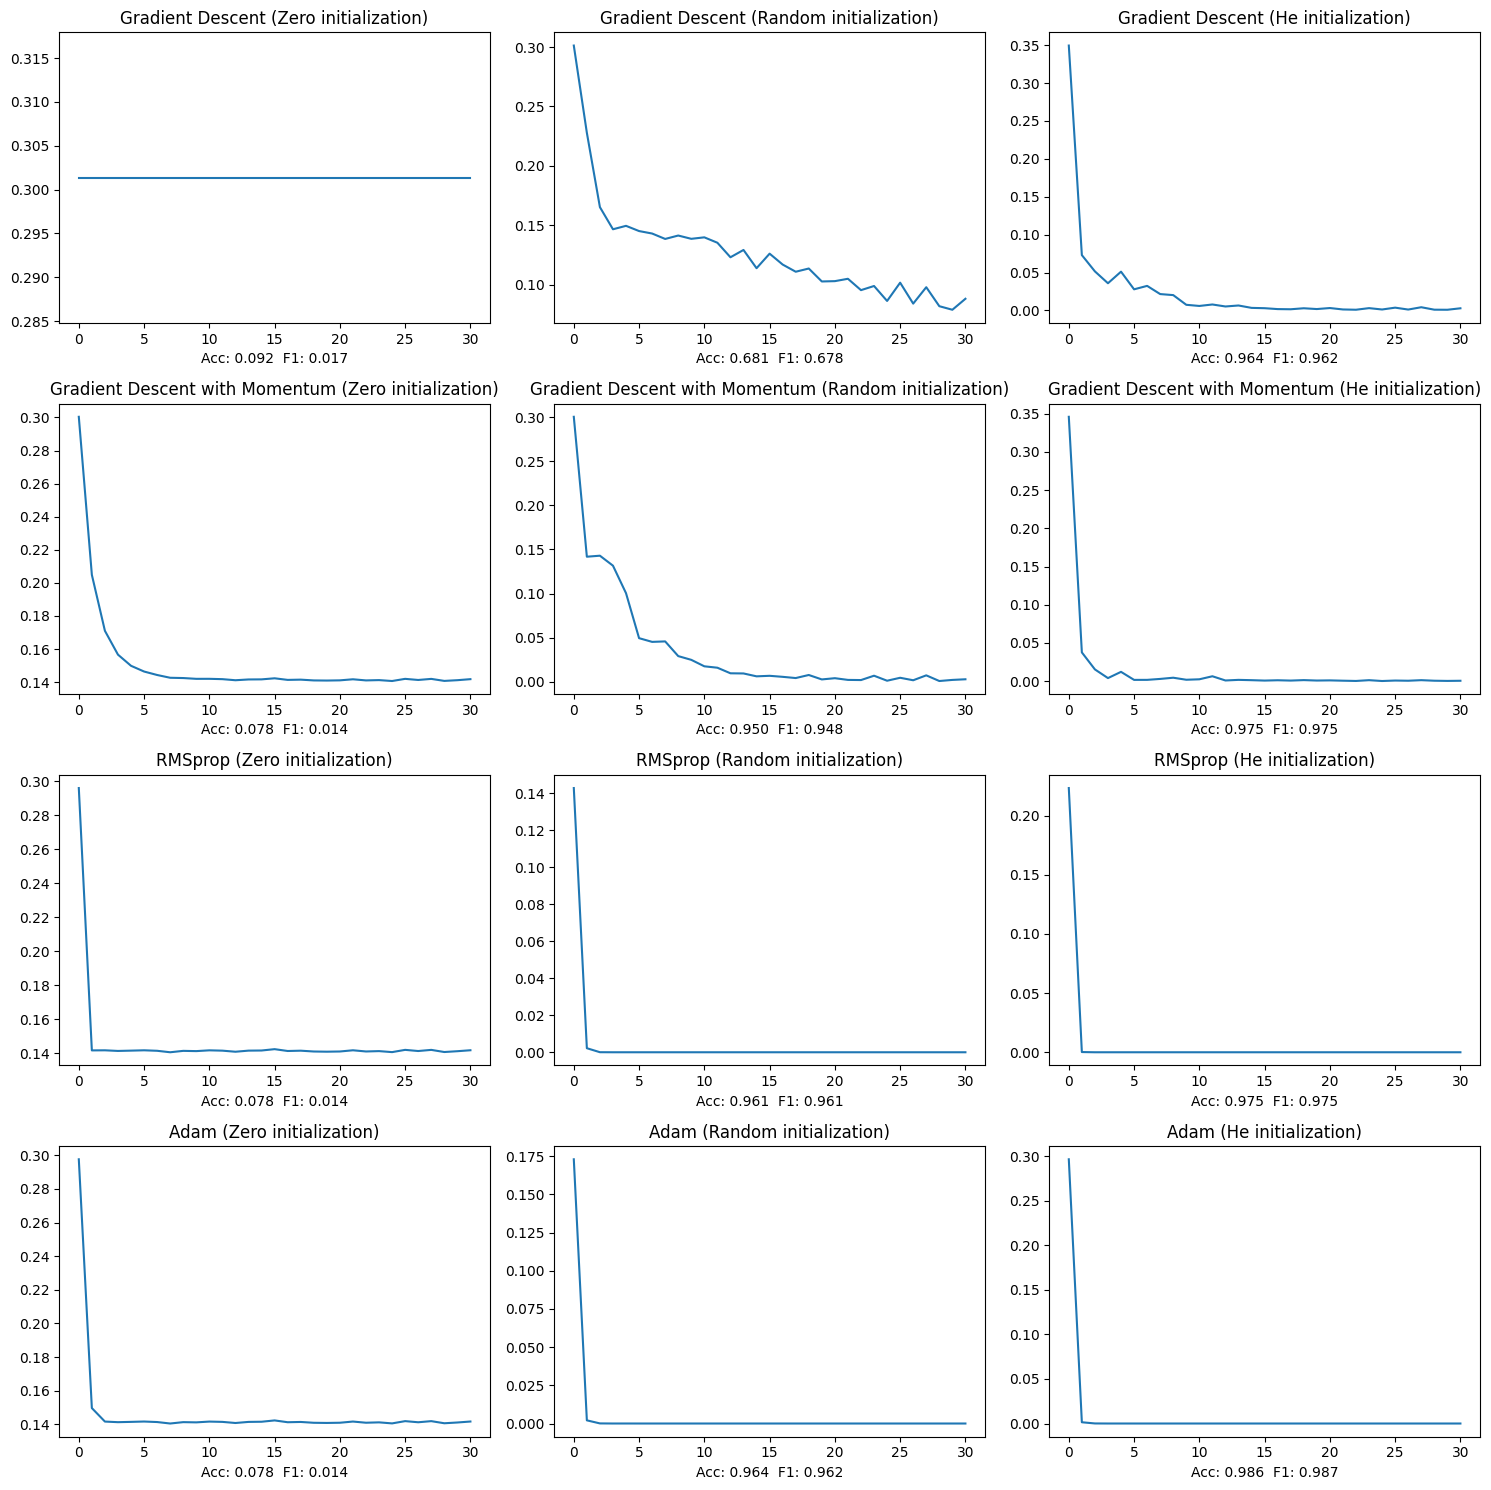

<Figure size 640x480 with 0 Axes>

In [10]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Define labels for each subplot
subplot_labels = [
    ['Gradient Descent (Zero initialization)', 'Gradient Descent (Random initialization)', 'Gradient Descent (He initialization)'],
    ['Gradient Descent with Momentum (Zero initialization)', 'Gradient Descent with Momentum (Random initialization)', 'Gradient Descent with Momentum (He initialization)'],
    ['RMSprop (Zero initialization)', 'RMSprop (Random initialization)', 'RMSprop (He initialization)'],
    ['Adam (Zero initialization)', 'Adam (Random initialization)', 'Adam (He initialization)']
]

# Plot each dataset and add labels
for i in range(4):  # Rows
    for j in range(3):  # Columns
        axs[i, j].plot(plots[i*3 + j], label=subplot_labels[i][j])
        axs[i, j].set_title(subplot_labels[i][j])  # Set subplot title
        axs[i, j].set_xlabel(f'Acc: {accuracies[i*3 + j]:.3f}  F1: {f1_scores[i*3 + j]:.3f}')  # Set common x-axis label if needed

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()
plt.savefig('results.png')

## Results
We can see that parameters initialization and the type of optimization algorithm chosen are crucial aspect that can lead to a faster training and a better performance.

Results (accuracy) are summarized in the following table:

|                  | Zero Initialization | Random Initialization | He Initialization |
|------------------|---------------------|-----------------------|-------------------|
| **Gradient Descent** | 0.092               | 0.681                 | 0.964             |
| **Momentum**         | 0.078               | 0.950                 | 0.975             |
| **RMSprop**          | 0.078               | 0.961                 | 0.975             |
| **Adam**             | 0.078               | 0.964                 | 0.986             |


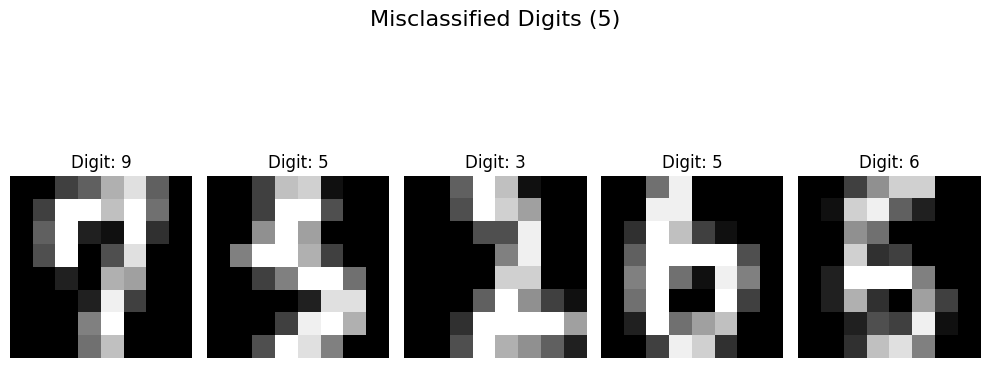

In [11]:
misclassified_indices = np.where(y_pred != np.argmax(y_test, axis=1))
misclassified_images = X_test[misclassified_indices]
misclassified_images = misclassified_images.reshape(misclassified_images.shape[0], 8, 8)
display_pixellated_images(misclassified_images, y_pred[misclassified_indices], rows=1, cols=5, title=f'Misclassified Digits ({len(misclassified_images)})')

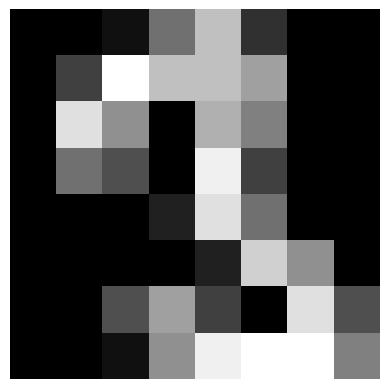

I predicted 3


In [12]:
index = random.randint(0, len(images))
show_digit(images[index])

print(f"I predicted {model.predict(images[index].reshape(1, -1).T)[0]}")